![cyber_photo](cyber_photo.jpg)

Cyber threats are a growing concern for organizations worldwide. These threats take many forms, including malware, phishing, and denial-of-service (DOS) attacks, compromising sensitive information and disrupting operations. The increasing sophistication and frequency of these attacks make it imperative for organizations to adopt advanced security measures. Traditional threat detection methods often fall short due to their inability to adapt to new and evolving threats. This is where deep learning models come into play.

Deep learning models can analyze vast amounts of data and identify patterns that may not be immediately obvious to human analysts. By leveraging these models, organizations can proactively detect and mitigate cyber threats, safeguarding their sensitive information and ensuring operational continuity.

As a cybersecurity analyst, you identify and mitigate these threats. In this project, you will design and implement a deep learning model to detect cyber threats. The BETH dataset simulates real-world logs, providing a rich source of information for training and testing your model. The data has already undergone preprocessing, and we have a target label, `sus_label`, indicating whether an event is malicious (1) or benign (0).

By successfully developing this model, you will contribute to enhancing cybersecurity measures and protecting organizations from potentially devastating cyber attacks.


### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

In [39]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
# from sklearn.metrics import accuracy_score  # uncomment to use sklearn

In [40]:
# Load preprocessed data
train_df = pd.read_csv('labelled_train.csv')
test_df = pd.read_csv('labelled_test.csv')
val_df = pd.read_csv('labelled_validation.csv')

# View the first 5 rows of training set+
train_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [41]:
# Start coding here
# Use as many cells as you need
import torch
import torch.nn as nn

class MalwareDetector(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- 1. Embedding Layers ---
        # (num_embeddings, embedding_dim)
        # We add +1 to sizes for the "Unknown" bucket at index 0
        self.emb_process = nn.Embedding(546 + 1, 4) 
        # Note: We'll need to confirm the exact max IDs for thread/parent later, 
        # but for now we'll stick to the placeholder sizes we discussed.
        self.emb_thread = nn.Embedding(1000 + 1, 4) 
        self.emb_parent = nn.Embedding(1000 + 1, 4) 
        self.emb_return = nn.Embedding(524 + 1, 4)

        # -- Define the Dropout Layer 🛑
        # We drop 50% of the embeddings to force the model to look elsewhere.
        self.emb_dropout = nn.Dropout(p=0.5)
        
        # --- 2. The Main Network ---
        self.input_dim = 30 # Calculated: 16 (embs) + 7 (user) + 6 (mount) + 1 (args)
        
        self.layer1 = nn.Linear(self.input_dim, 16)
        self.layer2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, process_id, thread_id, parent_id, return_val, user_oh, mount_oh, args_num):
        # 1. Get Embeddings
        e1 = self.emb_process(process_id)
        e2 = self.emb_thread(thread_id)
        e3 = self.emb_parent(parent_id)
        e4 = self.emb_return(return_val)
        
        # 2. Reshape scalar to (Batch, 1)
        args_num = args_num.view(-1, 1)
        
        # 3. Concatenate Everything
        x = torch.cat([e1, e2, e3, e4, user_oh, mount_oh, args_num], dim=1)

        # --- Apply Dropout Here ---
        # This randomly zeros out parts of the input vector
        x = self.emb_dropout(x)
        
        # 4. Pass through layers
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        
        return x

In [42]:
list(sorted(train_df["mountNamespace"].unique()))

[4026531840, 4026532217, 4026532229, 4026532231, 4026532232, 4026532288]

In [43]:
import torch
import numpy as np
import pandas as pd

# --- Configuration ---
# We define our exact known categories here to ensure fixed input sizes
KNOWN_USERS = list(sorted(train_df["userId"].unique()))  # Example list of 7 user IDs
KNOWN_MOUNTS = list(sorted(train_df["mountNamespace"].unique())) # Example 6 mounts

def build_vocab(df, columns):
    """
    Builds indices for Embedding columns.
    Returns: { 'col_name': { 'value': index, ... } }
    """
    vocab = {}
    for col in columns:
        unique_vals = df[col].unique()
        # Start index at 1, reserving 0 for 'Unknown'
        vocab[col] = {val: i + 1 for i, val in enumerate(unique_vals)}
    return vocab

def one_hot_encode(val, known_categories):
    """
    Manually creates a One-Hot vector to ensure fixed size.
    If val is not in known_categories, returns a vector of all zeros (or a specific unknown index).
    """
    # Create a vector of zeros with length equal to our known categories
    vec = np.zeros(len(known_categories), dtype=np.float32)
    
    try:
        # Find the position of the current value
        idx = known_categories.index(val)
        vec[idx] = 1.0
    except ValueError:
        # If value is not in our known list, we leave it as all zeros 
        # (This acts as an implicit "Other" bucket)
        pass 
        
    return vec

def preprocess_data(df, vocab_maps):
    """
    Converts a raw DataFrame into the exact Tensors the model needs.
    """
    
    # --- 1. Process Embeddings (Indices) ---
    # We use .apply to map every value to its index, defaulting to 0
    proc_idxs = df['processId'].apply(lambda x: vocab_maps['processId'].get(x, 0)).values
    thread_idxs = df['threadId'].apply(lambda x: vocab_maps['threadId'].get(x, 0)).values
    parent_idxs = df['parentProcessId'].apply(lambda x: vocab_maps['parentProcessId'].get(x, 0)).values
    return_idxs = df['returnValue'].apply(lambda x: vocab_maps['returnValue'].get(x, 0)).values
    
    # Convert to LongTensors (integers) for Embedding layers
    t_process = torch.tensor(proc_idxs, dtype=torch.long)
    t_thread = torch.tensor(thread_idxs, dtype=torch.long)
    t_parent = torch.tensor(parent_idxs, dtype=torch.long)
    t_return = torch.tensor(return_idxs, dtype=torch.long)
    
    # --- 2. Process One-Hots (Floats) ---
    # We apply our strict one_hot_encode function
    # Result is a list of arrays, so we stack them into a 2D matrix
    user_list = df['userId'].apply(lambda x: one_hot_encode(x, KNOWN_USERS)).tolist()
    mount_list = df['mountNamespace'].apply(lambda x: one_hot_encode(x, KNOWN_MOUNTS)).tolist()
    
    t_user = torch.tensor(user_list, dtype=torch.float32)   # Shape: (Batch, 7)
    t_mount = torch.tensor(mount_list, dtype=torch.float32) # Shape: (Batch, 6)
    
    # --- 3. Process Scalar (Log1p + Scale) ---
    # Apply log1p: log(1 + x)
    args_log = np.log1p(df['argsNum'].values)
    
    # Optional: If you want to scale it further (e.g. divide by max), do it here.
    # For now, raw log1p is usually safe enough.
    t_args = torch.tensor(args_log, dtype=torch.float32) # Shape: (Batch)
    
    # --- 4. Get Labels ---
    t_labels = torch.tensor(df['sus_label'].values, dtype=torch.float32).view(-1, 1)
    
    return t_process, t_thread, t_parent, t_return, t_user, t_mount, t_args, t_labels

# Usage Example:
# 1. Setup Vocab (Do this ONCE with your training data)
emb_cols = ['processId', 'threadId', 'parentProcessId', 'returnValue']
vocab_maps = build_vocab(train_df, emb_cols)

# 2. Convert Data
inputs = preprocess_data(train_df, vocab_maps)

In [111]:
dataset = TensorDataset(*inputs) 
# batch_size=2 means we process 2 rows at a time
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

# --- 4. Initialize Model & Training Tools ---
model = MalwareDetector()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 5. The Training Loop 🏋️ ---
num_epochs = 12

print("Starting Training...")
for epoch in range(num_epochs):
    total_loss = 0
    
    # Iterate over batches
    for batch in dataloader:
        # Unpack the batch (matches the order returned by preprocess_data)
        b_proc, b_thread, b_parent, b_ret, b_user, b_mount, b_args, b_labels = batch

        # 1. Ensure labels are flat (1D) before we start
        labels_flat = b_labels.squeeze()
        # Generate random probabilities for the "coin flip"
        probs = torch.rand_like(labels_flat, dtype=torch.float)
        # Create the mask: (Is Malicious) AND (Coin Flip < 50%)
        mask = (probs < 0.13)
        # Overwrite the Parent Process ID with 0 (Unknown) where mask is True
        b_parent[mask] = 0
        #b_ret[mask] = 0

        
        # A. Zero Gradients (Clean the workspace!)
        optimizer.zero_grad()
        
        # B. Forward Pass
        outputs = model(b_proc, b_thread, b_parent, b_ret, b_user, b_mount, b_args)
        
        # C. Calculate Loss
        loss = criterion(outputs, b_labels)
        
        # D. Backward Pass (Calculate gradients)
        loss.backward()
        
        # E. Update Weights
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}")

print("Training Complete!")

Starting Training...
Epoch 1/12 | Loss: 87.9183
Epoch 2/12 | Loss: 35.1059
Epoch 3/12 | Loss: 24.2524
Epoch 4/12 | Loss: 18.1909
Epoch 5/12 | Loss: 14.5369
Epoch 6/12 | Loss: 12.1574
Epoch 7/12 | Loss: 10.5761
Epoch 8/12 | Loss: 9.4972
Epoch 9/12 | Loss: 8.7590
Epoch 10/12 | Loss: 8.0566
Epoch 11/12 | Loss: 7.5419
Epoch 12/12 | Loss: 7.3645
Training Complete!


In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

def evaluate_model(model, dataloader, threshold=0.5):
    """
    Runs the model on the provided dataloader and calculates performance metrics.
    
    Args:
        model: The trained PyTorch model.
        dataloader: The validation or test DataLoader.
        threshold: The cutoff for classifying as Malicious (default 0.5).
        
    Returns:
        metrics: A dictionary containing Accuracy, Precision, Recall, F1, and the Confusion Matrix.
    """
    model.eval() # Set model to evaluation mode (turns off Dropout, etc.)
    
    all_labels = []
    all_preds = []
    
    # 1. Disable Gradient Calculation (Save Memory/Speed)
    with torch.no_grad():
        for batch in dataloader:
            # Unpack batch (Adjust indices based on your exact preprocess_data return)
            b_proc, b_thread, b_parent, b_ret, b_user, b_mount, b_args, b_labels = batch
            
            # 2. Get Raw Predictions (Probabilities)
            outputs = model(b_proc, b_thread, b_parent, b_ret, b_user, b_mount, b_args)
            
            # 3. Collect Labels and Predictions
            all_labels.extend(b_labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    # 4. Convert lists to numpy arrays
    # Flatten arrays to shape (N,) instead of (N, 1)
    y_true = np.array(all_labels).flatten()
    y_probs = np.array(all_preds).flatten()
    
    # 5. Apply Threshold to get Binary 0 or 1
    y_pred_bin = (y_probs >= threshold).astype(int)
    
    # 6. Calculate Metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_bin),
        'precision': precision_score(y_true, y_pred_bin, zero_division=0),
        'recall': recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': f1_score(y_true, y_pred_bin, zero_division=0),
        'conf_matrix': confusion_matrix(y_true, y_pred_bin)
    }
    
    return metrics

# --- Usage Example ---
# Assuming you have a 'val_loader' ready
# results = evaluate_model(model, val_loader)
# print(f"F1 Score: {results['f1']:.4f}")

In [112]:
#vocab_maps = build_vocab(train_df, emb_cols)

inputs = preprocess_data(val_df, vocab_maps)

val_dataset = TensorDataset(*inputs)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

# --- 4. Run Evaluation ---
# We use the function we defined in the previous step
results = evaluate_model(model, val_loader, threshold=0.8)

print(f"Accuracy:  {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall:    {results['recall']:.4f}")
print(f"F1 Score:  {results['f1']:.4f}")
print("\nConfusion Matrix:")
print(results['conf_matrix'])

Accuracy:  0.7720
Precision: 0.0176
Recall:    0.9822
F1 Score:  0.0346

Confusion Matrix:
[[145117  43064]
 [    14    772]]


In [109]:
#vocab_maps = build_vocab(train_df, emb_cols)

inputs = preprocess_data(test_df, vocab_maps)

test_dataset = TensorDataset(*inputs)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

# --- 4. Run Evaluation ---
# We use the function we defined in the previous step
results = evaluate_model(model, test_loader, threshold=0.5)

print(f"Accuracy:  {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall:    {results['recall']:.4f}")
print(f"F1 Score:  {results['f1']:.4f}")
print("\nConfusion Matrix:")
print(results['conf_matrix'])

Accuracy:  0.0934
Precision: 1.0000
Recall:    0.0008
F1 Score:  0.0016

Confusion Matrix:
[[ 17508      0]
 [171323    136]]


In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def analyze_malware_shift(df_val, df_test, vocab_maps, col_name='processId'):
    """
    Compares the distribution of a feature between Validation and Test sets,
    specifically for Malicious samples.
    """
    print(f"--- Analyzing Feature: {col_name} ---")
    
    # 1. Filter for MALICIOUS samples only (sus_label == 1)
    # We only care if the attacks look different, not the safe traffic.
    val_mal = df_val[(df_val['sus_label'] == 1)].copy()
    test_mal = df_test[df_test['sus_label'] == 1].copy()
    
    # 2. Map the Raw Values to Indices (using the Training Vocab)
    # This simulates exactly what the model sees (0 = Unknown)
    val_indices = val_mal[col_name].apply(lambda x: vocab_maps[col_name].get(x, 0))
    test_indices = test_mal[col_name].apply(lambda x: vocab_maps[col_name].get(x, 0))
    
    # 3. VISUALIZATION: Histograms 📊
    plt.figure(figsize=(12, 5))
    
    # Validation Plot
    plt.subplot(1, 2, 1)
    plt.hist(val_indices, bins=20, color='blue', alpha=0.7, label='Validation')
    plt.title(f"Validation Set (Malicious Only)\n{col_name} Indices")
    plt.xlabel("Index (0 is Unknown)")
    plt.ylabel("Count")
    plt.legend()
    
    # Test Plot
    plt.subplot(1, 2, 2)
    plt.hist(test_indices, bins=20, color='red', alpha=0.7, label='Test')
    plt.title(f"Test Set (Malicious Only)\n{col_name} Indices")
    plt.xlabel("Index (0 is Unknown)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 4. HYPOTHESIS TEST: Chi-Squared 📐
    # Null Hypothesis (H0): The proportion of "Unknowns" (Index 0) is the same.
    # Alt Hypothesis (H1): The proportion of "Unknowns" is different (Drift occurred).
    
    # Count [Unknowns, Knowns] for both sets
    val_zeros = (val_indices == 0).sum()
    val_known = (val_indices > 0).sum()
    
    test_zeros = (test_indices == 0).sum()
    test_known = (test_indices > 0).sum()
    
    # Contingency Table
    #           Unknown | Known
    # Validation [  A   ,   B  ]
    # Test       [  C   ,   D  ]
    contingency = [[val_zeros, val_known], 
                   [test_zeros, test_known]]
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print(f"Stats for {col_name}:")
    print(f"  Validation Unknowns: {val_zeros} ({val_zeros/len(val_indices):.2%})")
    print(f"  Test Unknowns:       {test_zeros} ({test_zeros/len(test_indices):.2%})")
    print(f"  Chi-Squared p-value: {p:.5f}")
    
    if p < 0.05:
        print("  🚨 SIGNIFICANT DISTRIBUTION SHIFT DETECTED!")
    else:
        print("  ✅ Distribution looks consistent.")
    print("-" * 30)

# --- Usage Example ---
# analyze_malware_shift(df_val, df_test, vocab_maps, 'processId')

In [32]:
train_df.columns

Index(['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace',
       'argsNum', 'returnValue', 'sus_label'],
      dtype='object')

--- Analyzing Feature: threadId ---


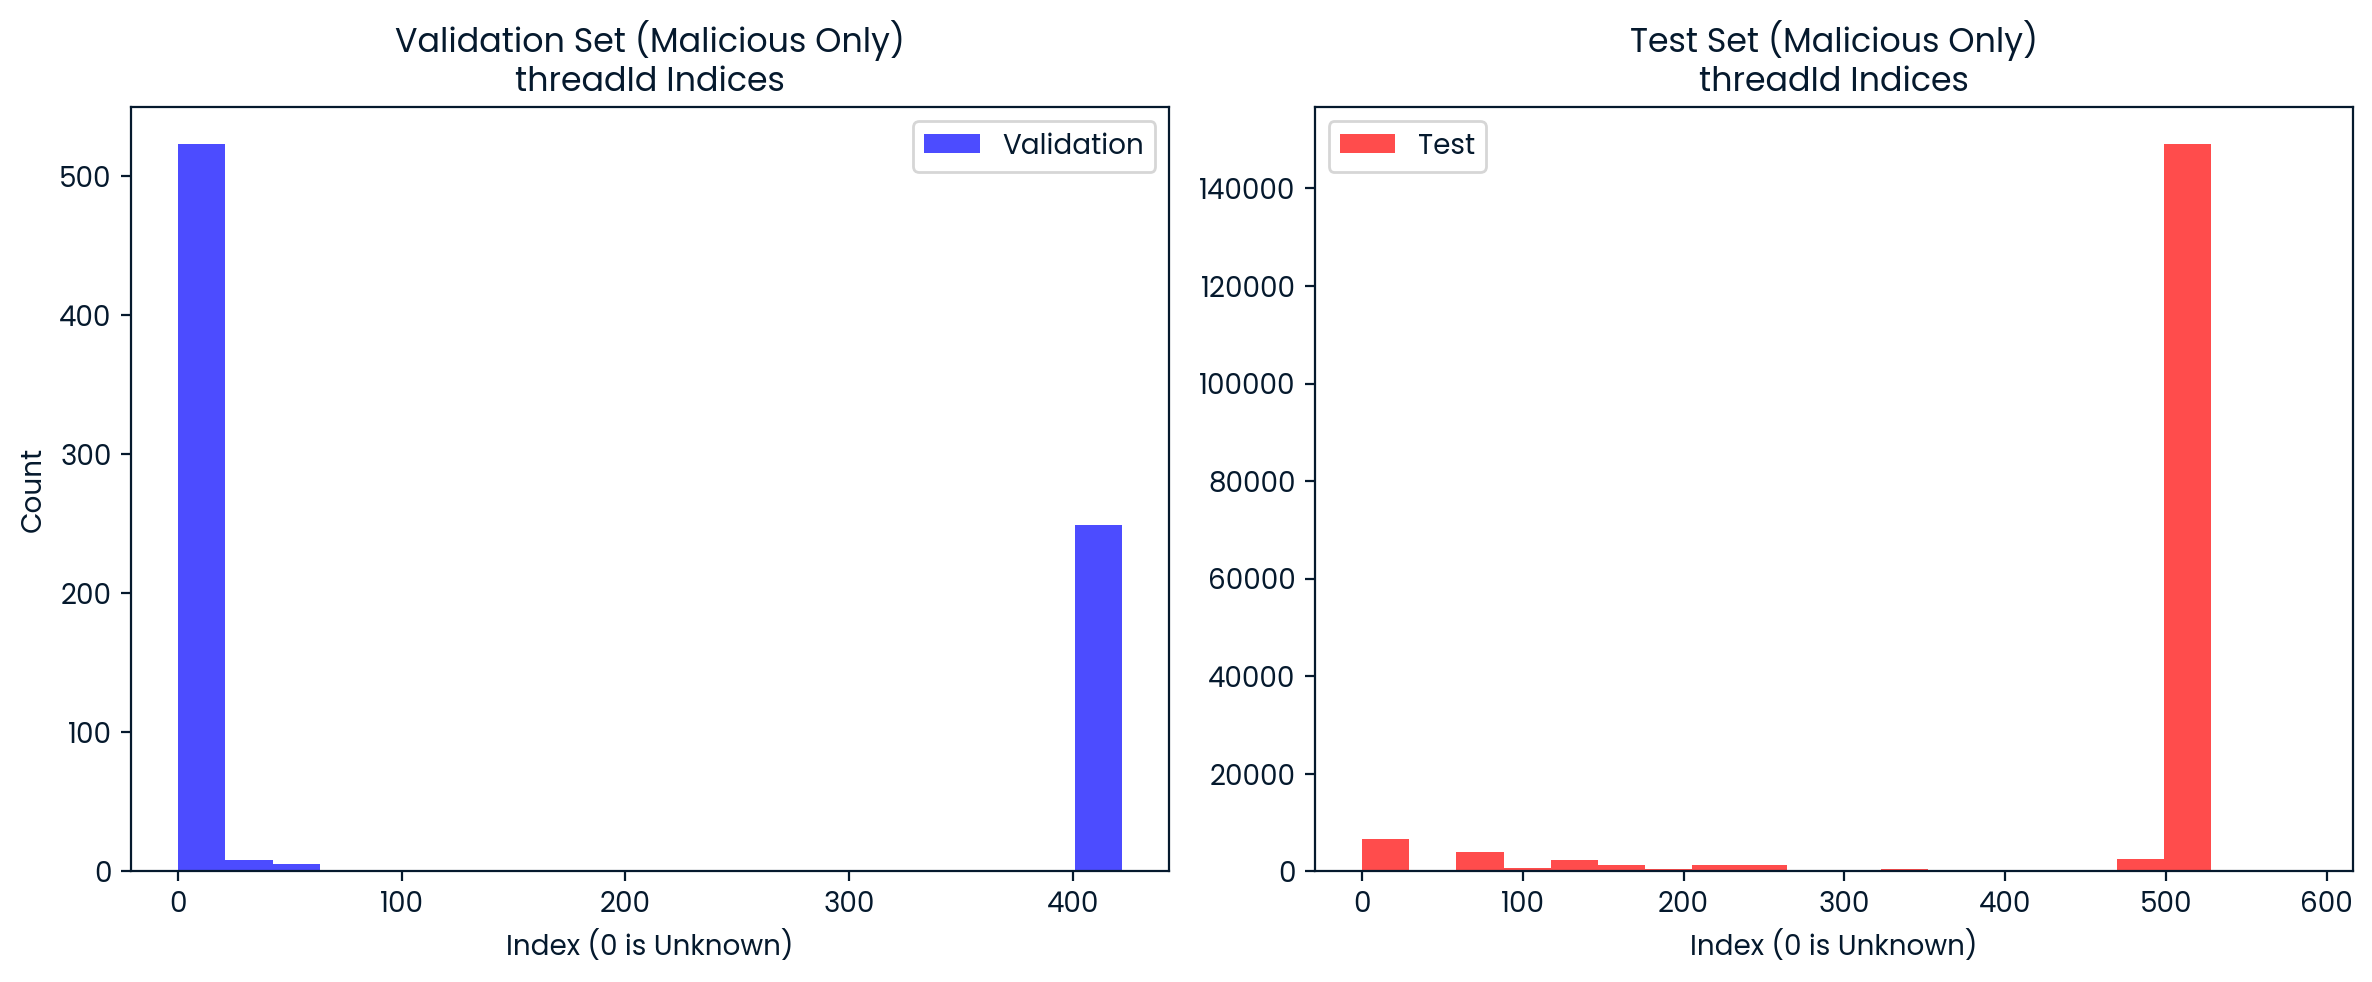

Stats for threadId:
  Validation Unknowns: 523 (66.54%)
  Test Unknowns:       440 (0.26%)
  Chi-Squared p-value: 0.00000
  🚨 SIGNIFICANT DISTRIBUTION SHIFT DETECTED!
------------------------------


In [82]:
analyze_malware_shift(val_df, test_df, vocab_maps, 'threadId')

In [86]:
# 1. Validation Data (Safe entries that look "Unknown")
# We filter for Safe Label (0) but where the Parent ID mapped to 0
safe_unknowns = val_df[(val_df['sus_label'] == 0) & (val_df['parentProcessId'].map(vocab_maps['parentProcessId']).fillna(0) == 0)]

# 2. Test Data (Attacks that look "Unknown")
# We filter for Malicious Label (1) where Parent ID mapped to 0
malicious_unknowns = test_df[(test_df['sus_label'] == 1) & (test_df['parentProcessId'].map(vocab_maps['parentProcessId']).fillna(0) == 0)]

# Compare their Arguments
print(f"Safe Unknowns - Avg Args: {safe_unknowns['argsNum'].mean():.2f}")
print(f"Malicious Unknowns - Avg Args: {malicious_unknowns['argsNum'].mean():.2f}")

--- Safe Unknowns: Top User IDs ---
0    11308
Name: userId, dtype: int64

--- Malicious Unknowns: Top User IDs ---
1001    155836
0         9619
109         36
1000        15
Name: userId, dtype: int64


In [87]:
print("--- Safe Unknowns: Top User IDs ---")
# Show the top 5 most common users
print(safe_unknowns['userId'].value_counts().head())

print("\n--- Malicious Unknowns: Top User IDs ---")
print(malicious_unknowns['userId'].value_counts().head())

--- Safe Unknowns: Top User IDs ---
0    11308
Name: userId, dtype: int64

--- Malicious Unknowns: Top User IDs ---
1001    155836
0         9619
109         36
1000        15
Name: userId, dtype: int64
